<a href="https://colab.research.google.com/github/p-pashootan/Bioinformatics-course/blob/main/Array_express_Metastatic_melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gene expression data Analysis: Comparing Metastatic, Primary and Control Groups

Accession: E-GEOD-22301 (Array Express)


# Step 1: Library Installation and Loading

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("edgeR", "limma", "pheatmap"), force = TRUE)
install.packages("ggplot2")
install.packages("ggrepel")


library(edgeR)
library(limma)
library(pheatmap)
library(ggplot2)
library(ggrepel)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Installing package(s) 'edgeR', 'limma', 'pheatmap'

Old packages: 'generics'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: limma



# Step 2: Read and merge the sample tables
Read and merge all sample .txt files.

In [2]:
# Set the path to folder
folder_path <- "read-data"

# Get a list of all .txt files
file_list <- list.files(pattern = "\\.txt$")

# Sort the file list for consistency
file_list <- sort(file_list)

# Initialize an empty list to store data frames
expression_list <- list()

In [3]:
# Loop through each file and read data
for (file in file_list) {
  # Read the tab-delimited file
  data <- read.table(file, header = TRUE, sep = "\t", stringsAsFactors = FALSE)

  # Rename the VALUE column to the sample name (based on filename)
  sample_name <- tools::file_path_sans_ext(basename(file))
  colnames(data) <- c("GeneID", sample_name)

  # Add to the list
  expression_list[[sample_name]] <- data
}

In [4]:
# Merge all data frames by 'GeneID'
merged_data <- Reduce(function(x, y) merge(x, y, by = "GeneID"), expression_list)
write.table(merged_data, file = "merged_expression_matrix.txt", sep = "\t", quote = FALSE, row.names = FALSE)

# Step 3: Read the merged expression matrix and define groups

In [5]:
expr_data <- read.table("merged_expression_matrix.txt", header = TRUE, sep = "\t", row.names = 1)

# Replace with your actual column/sample names
sample_names <- colnames(expr_data)

# Manually define which samples belong to which group
control_samples <- c("GSM555116_sample_table", "GSM555117_sample_table", "GSM555118_sample_table", "GSM555135_sample_table")
metastatic_samples <- c("GSM555120_sample_table", "GSM555121_sample_table", "GSM555122_sample_table", "GSM555123_sample_table",
                        "GSM555124_sample_table", "GSM555125_sample_table", "GSM555126_sample_table", "GSM555127_sample_table",
                        "GSM555129_sample_table", "GSM555130_sample_table", "GSM555131_sample_table", "GSM555132_sample_table",
                        "GSM555128_sample_table", "GSM555137_sample_table")
primary_samples <- c("GSM555133_sample_table", "GSM555136_sample_table", "GSM555119_sample_table", "GSM555134_sample_table")


In [6]:
# Create a named vector for group numbers
group_num <- rep(NA, length(sample_names))
names(group_num) <- sample_names

# Assign numbers to each group
group_num[control_samples] <- 1
group_num[primary_samples] <- 2
group_num[metastatic_samples] <- 3

# Create the final matrix
group_matrix <- data.frame(
  Index = 1:22,
  SampleID = sample_names,
  Group = group_num
)
print(group_matrix, row.names = FALSE)

 Index               SampleID Group
     1 GSM555116_sample_table     1
     2 GSM555117_sample_table     1
     3 GSM555118_sample_table     1
     4 GSM555119_sample_table     2
     5 GSM555120_sample_table     3
     6 GSM555121_sample_table     3
     7 GSM555122_sample_table     3
     8 GSM555123_sample_table     3
     9 GSM555124_sample_table     3
    10 GSM555125_sample_table     3
    11 GSM555126_sample_table     3
    12 GSM555127_sample_table     3
    13 GSM555128_sample_table     3
    14 GSM555129_sample_table     3
    15 GSM555130_sample_table     3
    16 GSM555131_sample_table     3
    17 GSM555132_sample_table     3
    18 GSM555133_sample_table     2
    19 GSM555134_sample_table     2
    20 GSM555135_sample_table     1
    21 GSM555136_sample_table     2
    22 GSM555137_sample_table     3


# Step 4: Create DGEList and Normalize Data

In [7]:
counts <- as.matrix(expr_data)
dge <- DGEList(counts = counts)

# Convert group_num to factor with meaningful labels
group_factor <- factor(group_num, levels = c(1, 2, 3),
                       labels = c("Control", "Primary", "Metastatic"))

# Create design matrix
design <- model.matrix(~ 0 + group_factor)
colnames(design) <- levels(group_factor)  # Rename columns for clarity
print(design)


   Control Primary Metastatic
1        1       0          0
2        1       0          0
3        1       0          0
4        0       1          0
5        0       0          1
6        0       0          1
7        0       0          1
8        0       0          1
9        0       0          1
10       0       0          1
11       0       0          1
12       0       0          1
13       0       0          1
14       0       0          1
15       0       0          1
16       0       0          1
17       0       0          1
18       0       1          0
19       0       1          0
20       1       0          0
21       0       1          0
22       0       0          1
attr(,"assign")
[1] 1 1 1
attr(,"contrasts")
attr(,"contrasts")$group_factor
[1] "contr.treatment"



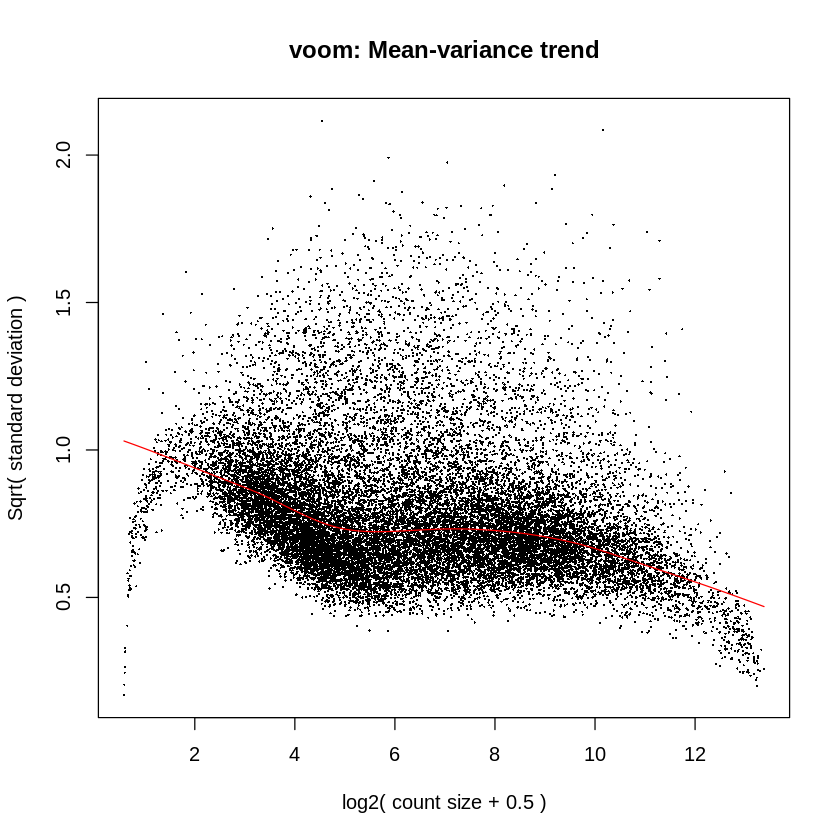

In [8]:
# Perform Voom Transformation
v <- voom(dge, design, plot=TRUE)

# Fit the Linear Model
fit <- lmFit(v, design)

# Step 5: Define Contrasts for Comparisons

In [9]:
# Convert numeric group to factor
group_factor <- factor(group_num, levels = c(1, 2, 3), labels = c("Control", "Primary", "Metastatic"))


# Define contrasts
contrast.matrix <- makeContrasts(
  Met_vs_Control = Metastatic - Control,
  Met_vs_Primary = Metastatic - Primary,
  levels = design
)

print(contrast.matrix)
# Fit contrasts and run eBayes
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# View top differentially expressed genes for each contrast
topTable(fit2, coef = "Met_vs_Control")
topTable(fit2, coef = "Met_vs_Primary")

            Contrasts
Levels       Met_vs_Control Met_vs_Primary
  Control                -1              0
  Primary                 0             -1
  Metastatic              1              1


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
219654_at,-2.164870,5.6499683,-10.989362,2.009458e-10,3.148077e-06,13.614408
211427_s_at,-4.429880,0.4144768,-10.720301,3.198185e-10,3.148077e-06,12.332652
210179_at,-4.933142,1.0597162,-10.557782,4.251286e-10,3.148077e-06,12.274173
204111_at,-2.250705,-0.1011987,-10.364204,5.990632e-10,3.327047e-06,11.754267
206706_at,-5.519541,0.2844384,-10.051434,1.052319e-09,4.675455e-06,11.324076
203544_s_at,-1.747556,6.0537383,-9.478372,3.045637e-09,9.665547e-06,11.184129
211478_s_at,-5.837562,0.9896188,-9.695490,2.026592e-09,7.503458e-06,11.097695
203717_at,-5.465894,2.8823250,-8.754820,1.235541e-08,3.430942e-05,9.891663
203716_s_at,-5.971659,0.8523375,-8.692204,1.399147e-08,3.453562e-05,9.418445


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
203758_at,-2.671501,2.9952574,-6.392859,1.928399e-06,0.01669251,4.536829
206011_at,-2.951660,1.3597221,-6.320171,2.278673e-06,0.01669251,4.243096
209970_x_at,-2.771008,4.2395382,-6.135357,3.493109e-06,0.01669251,4.181362
211366_x_at,-2.610458,4.2475875,-6.104016,3.757036e-06,0.01669251,4.108910
211367_s_at,-3.583694,2.0271306,-6.155230,3.335633e-06,0.01669251,4.008747
209218_at,-1.811495,6.5802912,-5.815541,7.383321e-06,0.02050256,3.757626
211368_s_at,-4.406774,2.4115431,-5.939752,5.513571e-06,0.01853919,3.668651
221211_s_at,-2.531870,0.9378618,-5.520138,1.488036e-05,0.03672969,2.784642
204684_at,-4.590579,2.3290480,-5.385115,2.055517e-05,0.04566332,2.650966


# Step 6: Get all DEGs

In [10]:
# Get all DEGs for Metastatic vs Control
deg_met_vs_ctrl <- topTable(fit2, coef = "Met_vs_Control", number = Inf)

# Get all DEGs for Metastatic vs Primary
deg_met_vs_prim <- topTable(fit2, coef = "Met_vs_Primary", number = Inf)

# Write to text files
write.table(deg_met_vs_ctrl, file = "DEGs_Met_vs_Control.txt", sep = "\t", quote = FALSE, row.names = TRUE)
write.table(deg_met_vs_prim, file = "DEGs_Met_vs_Primary.txt", sep = "\t", quote = FALSE, row.names = TRUE)


# Step 7: Create Visualizations

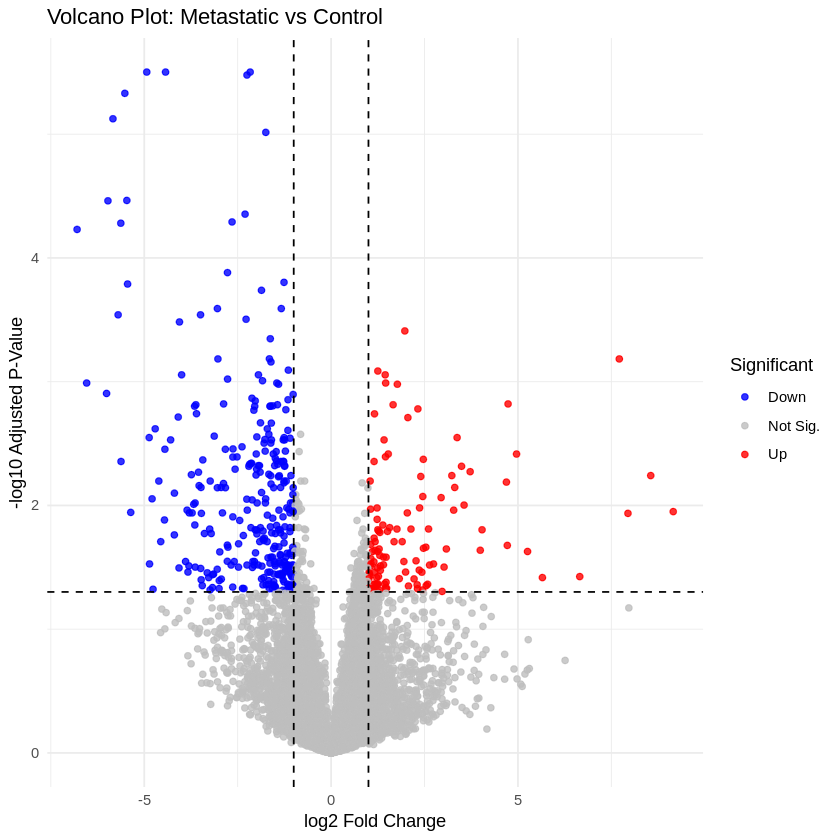

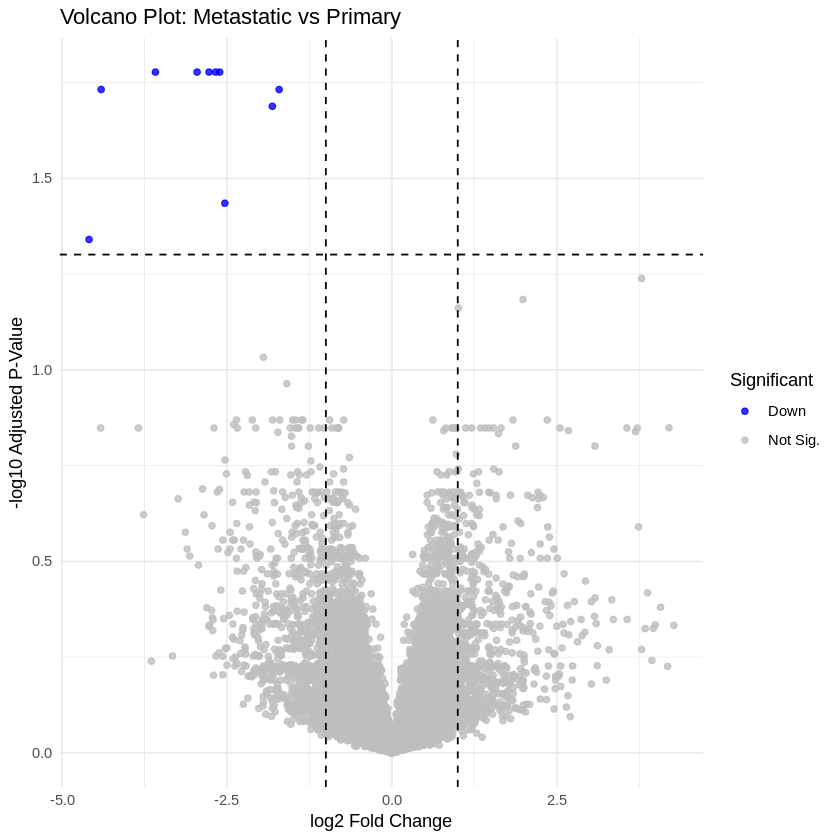

In [11]:
volcano_plot <- function(data, title, logFC_cutoff = 1, pval_cutoff = 0.05) {
  data$Significant <- "Not Sig."
  data$Significant[data$logFC >= logFC_cutoff & data$adj.P.Val < pval_cutoff] <- "Up"
  data$Significant[data$logFC <= -logFC_cutoff & data$adj.P.Val < pval_cutoff] <- "Down"

  ggplot(data, aes(x = logFC, y = -log10(adj.P.Val), color = Significant)) +
    geom_point(alpha = 0.8) +
    scale_color_manual(values = c("blue", "grey", "red")) +
    theme_minimal() +
    labs(title = title, x = "log2 Fold Change", y = "-log10 Adjusted P-Value") +
    geom_vline(xintercept = c(-logFC_cutoff, logFC_cutoff), linetype = "dashed", color = "black") +
    geom_hline(yintercept = -log10(pval_cutoff), linetype = "dashed", color = "black")
}
volcano_plot(deg_met_vs_ctrl, "Volcano Plot: Metastatic vs Control")
volcano_plot(deg_met_vs_prim, "Volcano Plot: Metastatic vs Primary")

In [12]:
# Select top 10 DEGs by adjusted p-value
top_genes_ctrl <- rownames(deg_met_vs_ctrl)[1:10]
top_genes_prim <- rownames(deg_met_vs_prim)[1:10]

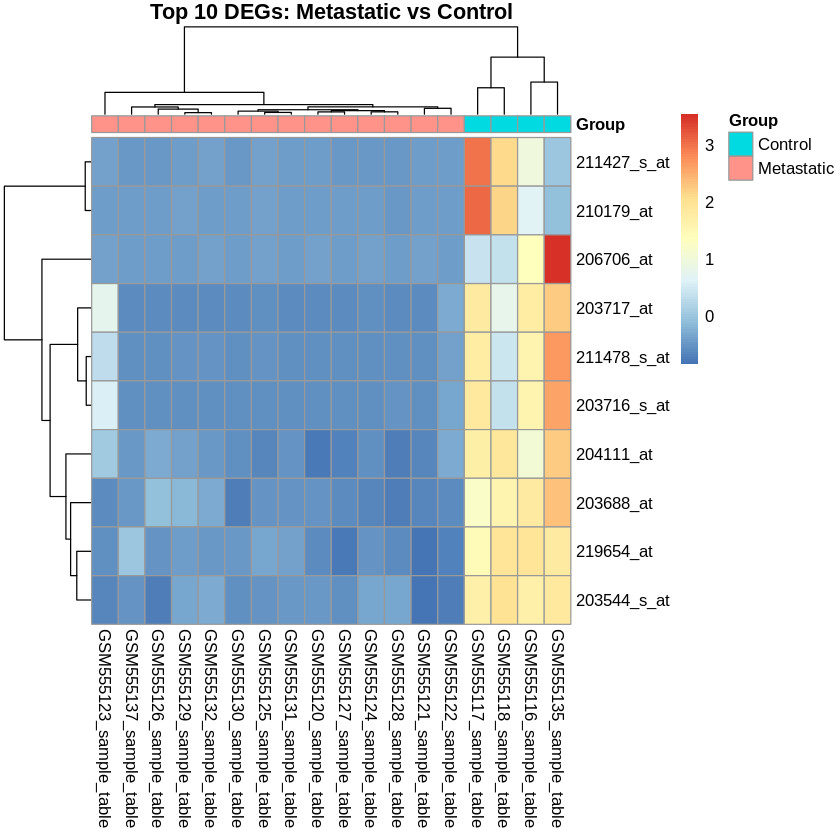

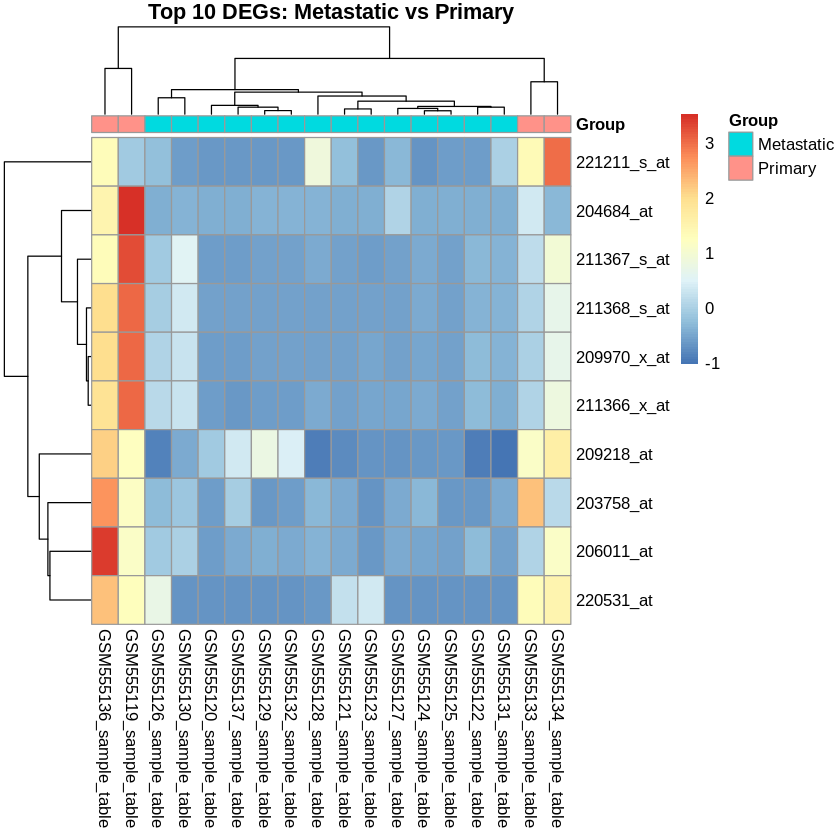

In [13]:
# Subset expression data for heatmap
expr_matrix_ctrl <- expr_data[top_genes_ctrl, c(control_samples, metastatic_samples)]
expr_matrix_prim <- expr_data[top_genes_prim, c(primary_samples, metastatic_samples)]

# Normalize
expr_matrix_ctrl_scaled <- t(scale(t(as.matrix(expr_matrix_ctrl))))
expr_matrix_prim_scaled <- t(scale(t(as.matrix(expr_matrix_prim))))

# Create annotation
annotation_ctrl <- data.frame(Group = factor(c(rep("Control", length(control_samples)), rep("Metastatic", length(metastatic_samples)))))
rownames(annotation_ctrl) <- c(control_samples, metastatic_samples)

annotation_prim <- data.frame(Group = factor(c(rep("Primary", length(primary_samples)), rep("Metastatic", length(metastatic_samples)))))
rownames(annotation_prim) <- c(primary_samples, metastatic_samples)

# Draw heatmaps
pheatmap(expr_matrix_ctrl_scaled, annotation_col = annotation_ctrl, main = "Top 10 DEGs: Metastatic vs Control")
pheatmap(expr_matrix_prim_scaled, annotation_col = annotation_prim, main = "Top 10 DEGs: Metastatic vs Primary")

# Step 8: Save Plots as PNGs

pdf 
  2

pdf 
  2

png 
  3

png 
  3

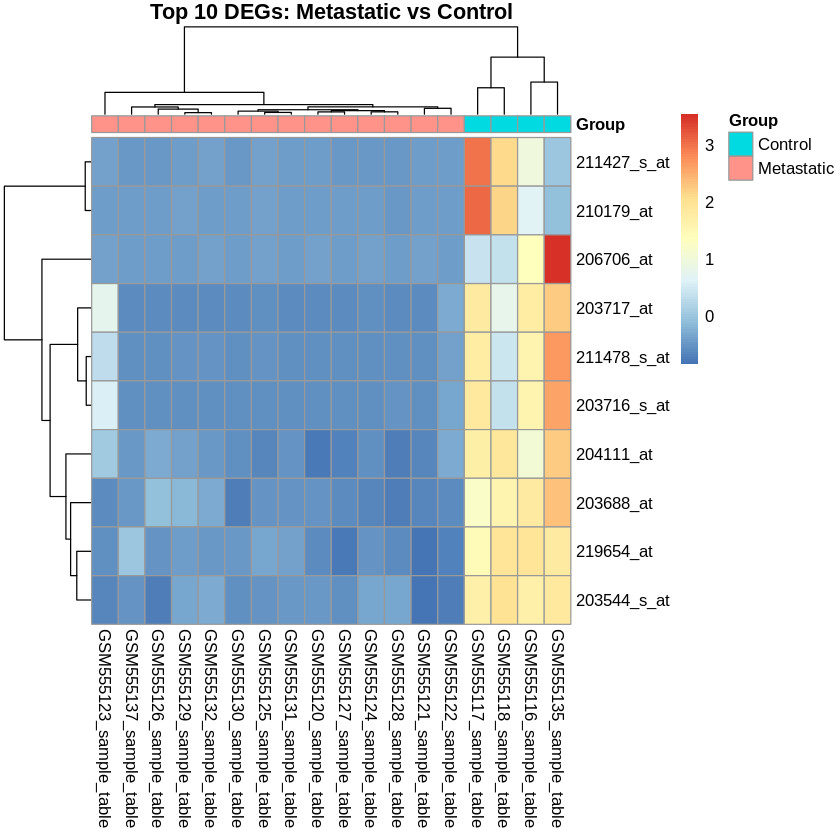

In [14]:


png("Volcano_Metastatic_vs_Control.png", width = 1200, height = 1000, res = 150)
volcano_plot(deg_met_vs_ctrl, "Volcano Plot: Metastatic vs Control")
dev.off()
png("Volcano_Metastatic_vs_Primary.png", width = 1200, height = 1000, res = 150)
volcano_plot(deg_met_vs_prim, "Volcano Plot: Metastatic vs Primary")
dev.off()

png("Heatmap_Top10_Met_vs_Control.png", width = 1200, height = 1000, res = 150)
pheatmap(expr_matrix_ctrl_scaled, annotation_col = annotation_ctrl, main = "Top 10 DEGs: Metastatic vs Control")
dev.off()
png("Heatmap_Top10_Met_vs_Primary.png", width = 1200, height = 1000, res = 150)
pheatmap(expr_matrix_prim_scaled, annotation_col = annotation_ctrl, main = "Top 10 DEGs: Metastatic vs Control")
dev.off()
